In [32]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, LeakyReLU, Dense, Add, UpSampling2D, Reshape, Conv2DTranspose, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow_datasets as tfds
import os
import time

In [33]:
ds = tfds.load('div2k/bicubic_x4', shuffle_files=True)

In [34]:
def resize_and_normalize(sample):
    sample['hr'] = tf.image.resize(sample['hr'], [2048, 2048])
    sample['lr'] = tf.image.resize(sample['lr'], [512, 512])

    sample['hr'] = tf.cast(sample['hr'], tf.float32) / 255.0
    sample['lr'] = tf.cast(sample['lr'], tf.float32) / 255.0

    return sample


ds_train_resized = ds["train"].map(resize_and_normalize)
ds_train_batched = ds_train_resized.batch(2)

ds_valid_resized = ds["validation"].map(resize_and_normalize)
ds_valid_batched = ds_valid_resized.batch(2)


In [35]:
def make_generator_model():

    input = Input(shape=(512, 512, 3))

    x = Reshape((512, 512, 3))(input)

    x = Conv2DTranspose(32, 2, strides=(1,1), padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(32, 2, strides=(1,1), padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(16, 2, strides=(2,2), padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(3, 2, strides=(2,2), padding="same")(x)
    x = LeakyReLU()(x)

    return Model(input, x)

gen_model = make_generator_model()
gen_model.summary()



Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 reshape_2 (Reshape)         (None, 512, 512, 3)       0         
                                                                 
 conv2d_transpose_8 (Conv2DT  (None, 512, 512, 32)     416       
 ranspose)                                                       
                                                                 
 batch_normalization_6 (Batc  (None, 512, 512, 32)     128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 512, 512, 32)      0         
                                                                 
 conv2d_transpose_9 (Conv2DT  (None, 512, 512, 32)     4128

(512, 512, 3)


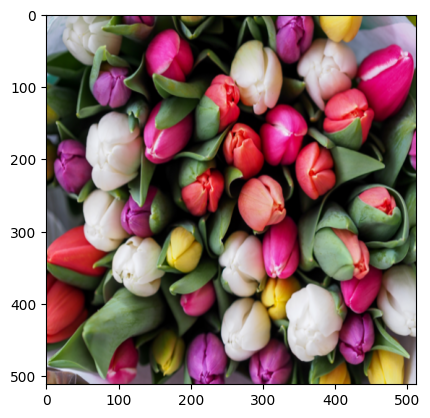

In [36]:
low_res_test_image = next(iter(ds_train_batched))['lr'][0]

plt.imshow(low_res_test_image)
print(low_res_test_image.shape)


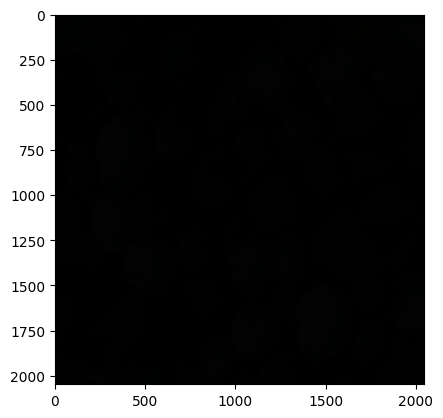

In [37]:
example_gen_image = gen_model(np.expand_dims(low_res_test_image, axis=0))[0]

plt.imshow(example_gen_image)

In [38]:
def make_discriminator_model():
    input = Input(shape=(2048,2048,3))
    x = Conv2D(32, (5,5), strides=(2,2), padding="same", input_shape=(2048,2048,3))(input)
    x = LeakyReLU()(x)

    x = Conv2D(32, (5,5), strides=(2,2), padding="same")(x)
    x = LeakyReLU()(x)

    x = Flatten()(x)
    x = Dense(1)(x)

    return Model(input, x)

discriminator_model = make_discriminator_model()
discriminator_model.summary()



Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 2048, 2048, 3)]   0         
                                                                 
 conv2d_4 (Conv2D)           (None, 1024, 1024, 32)    2432      
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 1024, 1024, 32)    0         
                                                                 
 conv2d_5 (Conv2D)           (None, 512, 512, 32)      25632     
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 512, 512, 32)      0         
                                                                 
 flatten_2 (Flatten)         (None, 8388608)           0         
                                                                 
 dense_2 (Dense)             (None, 1)                 8388

In [39]:
example_decision = discriminator_model(tf.expand_dims(example_gen_image, axis=0), training=False)

example_decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00117943]], dtype=float32)>

In [40]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
perceptual_loss = tf.keras.losses.Pe

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam()
discriminator_optimizer = tf.keras.optimizers.Adam()



In [41]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=gen_model,
                                 discriminator=discriminator_model)


In [51]:
EPOCHS = 5

def train_step(lr_image_batch, hr_image_batch):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_images = gen_model(lr_image_batch, training=True)

        real_output = discriminator_model(hr_image_batch, training=True)
        fake_output = discriminator_model(gen_images, training=True)

        disc_loss = discriminator_loss(real_output, fake_output)
        gen_loss = generator_loss(fake_output)
        print("gen_loss: ", gen_loss)

    gradient_gen = gen_tape.gradient(gen_loss, gen_model.trainable_variables)
    gradient_disc = disc_tape.gradient(disc_loss, discriminator_model.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradient_gen, gen_model.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradient_disc, discriminator_model.trainable_variables))


In [43]:
for i in iter(ds_train_batched):
    print(i["lr"].shape)
    break

(2, 512, 512, 3)


In [52]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for n, iter_item in enumerate(iter(ds_train_batched)):
            hr_image_batch = iter_item["hr"]
            lr_image_batch = iter_item["lr"]

            train_step(lr_image_batch, hr_image_batch)
            
        checkpoint.save(checkpoint_prefix)
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))





In [53]:
train(ds_train_batched, 1)

gen_loss:  tf.Tensor(383.4876, shape=(), dtype=float32)
gen_loss:  tf.Tensor(224.31253, shape=(), dtype=float32)
gen_loss:  tf.Tensor(350.05286, shape=(), dtype=float32)
gen_loss:  tf.Tensor(295.81427, shape=(), dtype=float32)
gen_loss:  tf.Tensor(231.34198, shape=(), dtype=float32)
gen_loss:  tf.Tensor(124.28611, shape=(), dtype=float32)
gen_loss:  tf.Tensor(193.99559, shape=(), dtype=float32)
gen_loss:  tf.Tensor(396.41138, shape=(), dtype=float32)
gen_loss:  tf.Tensor(213.08278, shape=(), dtype=float32)
gen_loss:  tf.Tensor(396.05316, shape=(), dtype=float32)
gen_loss:  tf.Tensor(324.43262, shape=(), dtype=float32)
gen_loss:  tf.Tensor(285.0114, shape=(), dtype=float32)
gen_loss:  tf.Tensor(446.7827, shape=(), dtype=float32)
gen_loss:  tf.Tensor(228.2013, shape=(), dtype=float32)
gen_loss:  tf.Tensor(331.49255, shape=(), dtype=float32)
gen_loss:  tf.Tensor(399.52686, shape=(), dtype=float32)
gen_loss:  tf.Tensor(207.22664, shape=(), dtype=float32)
gen_loss:  tf.Tensor(178.26506, sha